In [1]:
from mesh_generator import uniform_mesh
import matplotlib.pyplot as plt
import tensorflow as tf
import xarray as xr
import numpy as np

2022-08-10 00:48:42.411178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-10 00:48:42.411204: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


1. Mesh generation.

For mesh generation points, seperated from each on equal distances, are chosen and triangulated.

2022-08-08 20:09:53.992398: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-08 20:09:53.992427: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MIPTGorbunov): /proc/driver/nvidia/version does not exist
2022-08-08 20:09:53.992918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0, 0.5, 'latitude, rad')

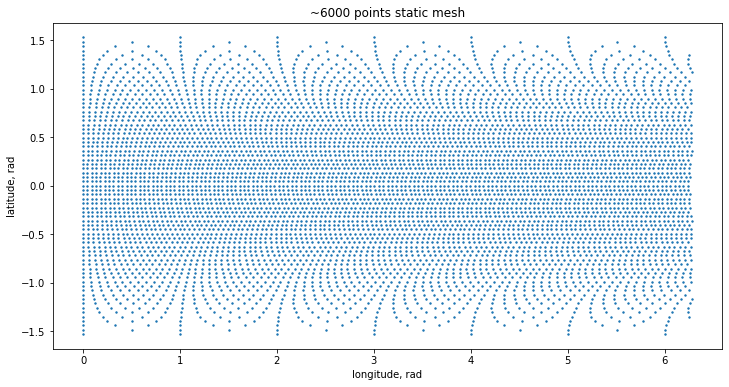

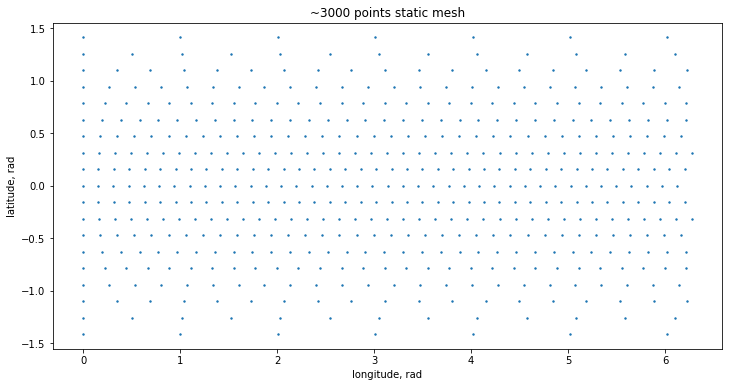

In [2]:
nodes, edges = uniform_mesh(70, 70)
plt.figure(figsize=(12, 6))
plt.scatter(nodes[:, 1], nodes[:, 0], s=2)
plt.xlabel('longitude, rad')
plt.ylabel('latitude, rad')
plt.title('~6000 points static mesh')
nodes, edges = uniform_mesh(20, 20)
plt.figure(figsize=(12, 6))
plt.title('~3000 points static mesh')
plt.scatter(nodes[:, 1], nodes[:, 0], s=2)
plt.xlabel('longitude, rad')
plt.ylabel('latitude, rad')

Obtained meshes on the globe.

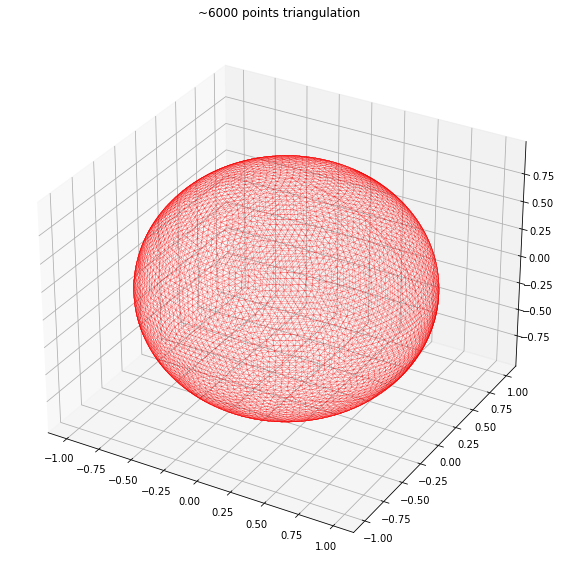

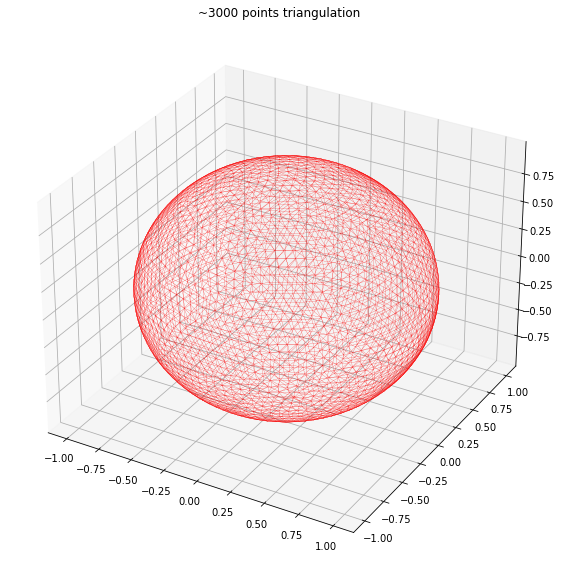

In [3]:
def get_cartesian(lat_res, long_res):
    nodes, edges = uniform_mesh(lat_res, long_res)
    lats = nodes[:, 0]
    longs = nodes[:, 1]
    cart_x = tf.cos(lats)*tf.cos(longs)
    cart_y = tf.cos(lats)*tf.sin(longs)
    cart_z = tf.sin(lats)
    return tf.stack([cart_x, cart_y, cart_z], axis=0), edges
fig = plt.figure(figsize=(10, 10))
cart, edges = get_cartesian(70, 70)
ax = fig.add_subplot(projection='3d')
plt.title('~6000 points triangulation')
for edge in tf.transpose(edges):
    ax.plot([cart[:, edge[0]][0], cart[:, edge[1]][0]], [cart[:, edge[0]][1], cart[:, edge[1]][1]], [cart[:, edge[0]][2], cart[:, edge[1]][2]], linewidth='0.1', color='red')

fig = plt.figure(figsize=(10, 10))
cart, edges = get_cartesian(50, 50)
ax = fig.add_subplot(projection='3d')
plt.title('~3000 points triangulation')
for edge in tf.transpose(edges):
    ax.plot([cart[:, edge[0]][0], cart[:, edge[1]][0]], [cart[:, edge[0]][1], cart[:, edge[1]][1]], [cart[:, edge[0]][2], cart[:, edge[1]][2]], linewidth='0.1', color='red')


2. Data preparation

Data is prepared by linear interpolation of given regular grid onto mesh. 6 physical values (u, v components of wind speed, vertical wind speed (all in $m/s$), temperature in $K$, geopotential in $m^2/s^2$ and realtive humidity in $\%$) on 4 levels of pressure are used. Initial .grib dataset is converted into .tfrecords.

In [3]:
#Loading training data
from input_pipeline import load_ds
training_files = ['dataset/training/200{}.grib.tfrecords'.format(i) for i in range(5, 8)]
train_ds = load_ds(*training_files)

Let's take a look at all the 6 features on the 1 bar pressure level.

Text(0.5, 1.0, 'Wind vector field')

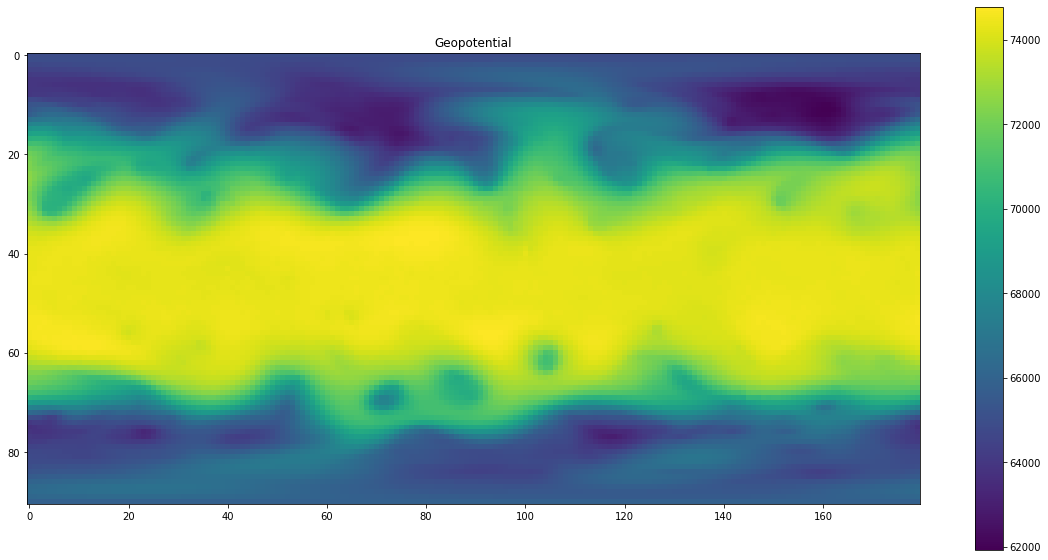

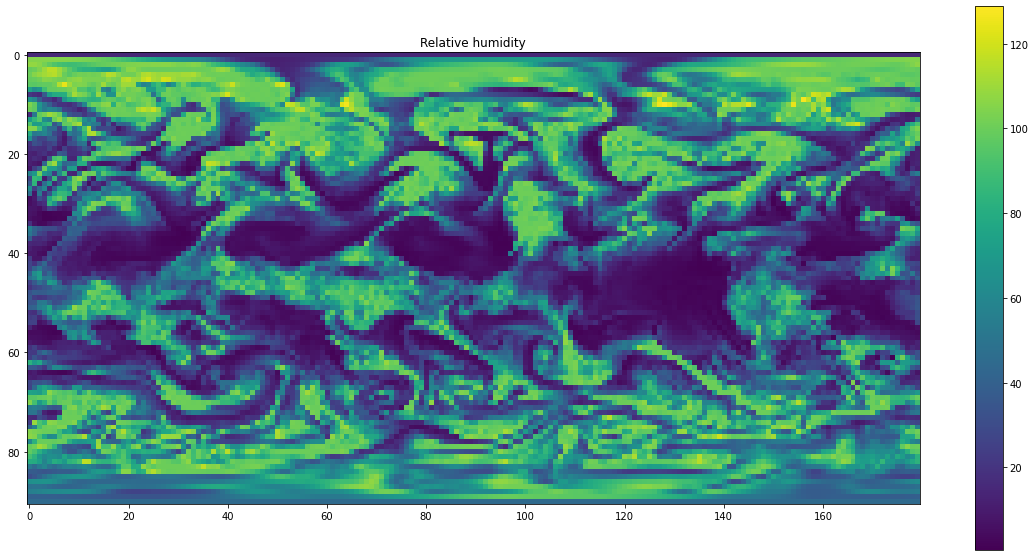

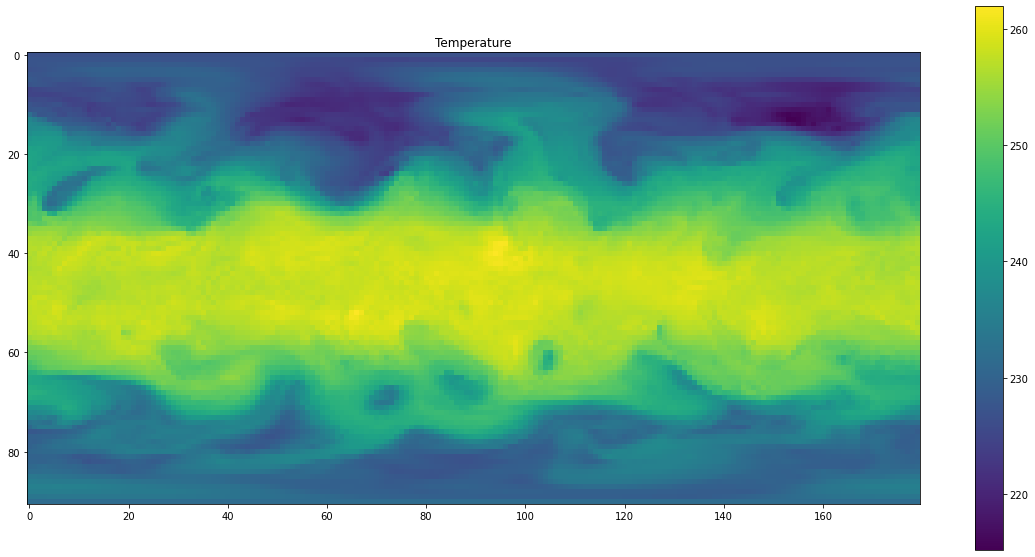

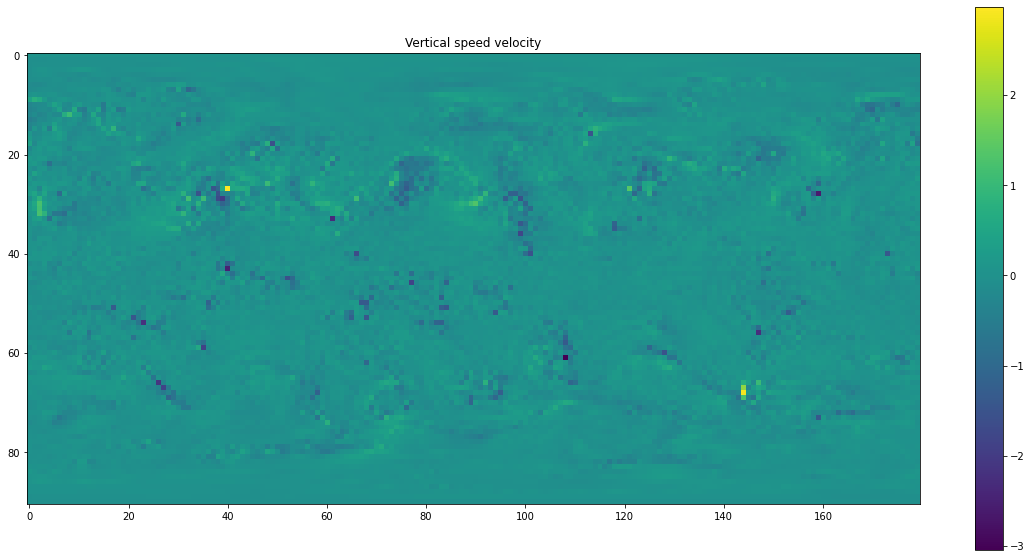

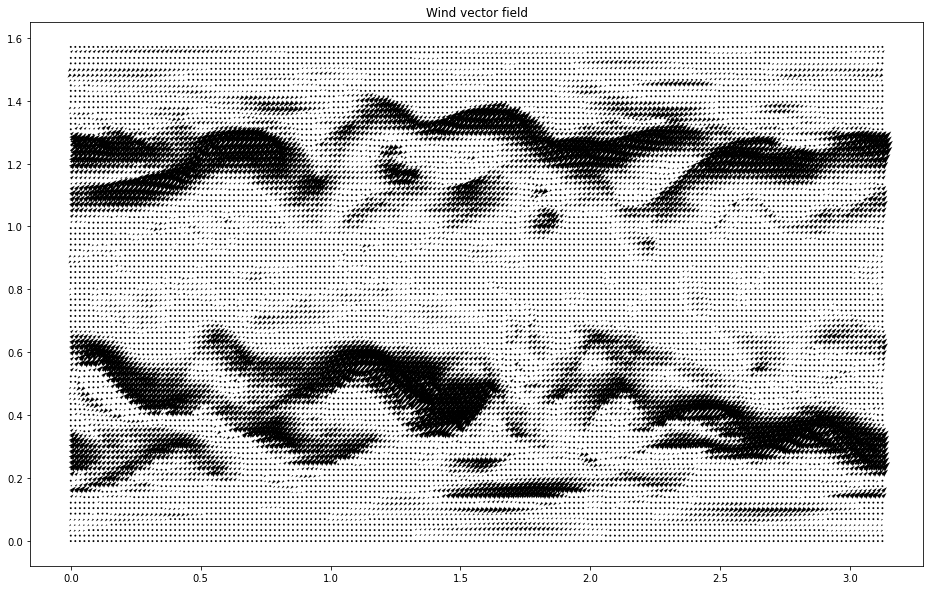

In [4]:
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(train_ds))[:, :, 0, 0])
plt.colorbar()
plt.title('Geopotential')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(train_ds))[:, :, 0, 1])
plt.colorbar()
plt.title('Relative humidity')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(train_ds))[:, :, 0, 2])
plt.colorbar()
plt.title('Temperature')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(train_ds))[:, :, 0, 5])
plt.colorbar()
plt.title('Vertical speed velocity')
plt.figure(figsize=(16, 10))
points = np.indices((91, 180))/180*np.pi
points = np.transpose(points, axes=[1, 2, 0])
points = points.reshape((-1, points.shape[-1]))
u = np.array(next(iter(train_ds))[:, :, 0, 3])
v = np.array(next(iter(train_ds))[:, :, 0, 3])
u = u.reshape((-1))
v = v.reshape((-1))
plt.quiver(points[:, 1], points[:, 0], u, v)
plt.title('Wind vector field')

Relative humidity at 4 pressure levels

Text(0.5, 1.0, '0.4 bar')

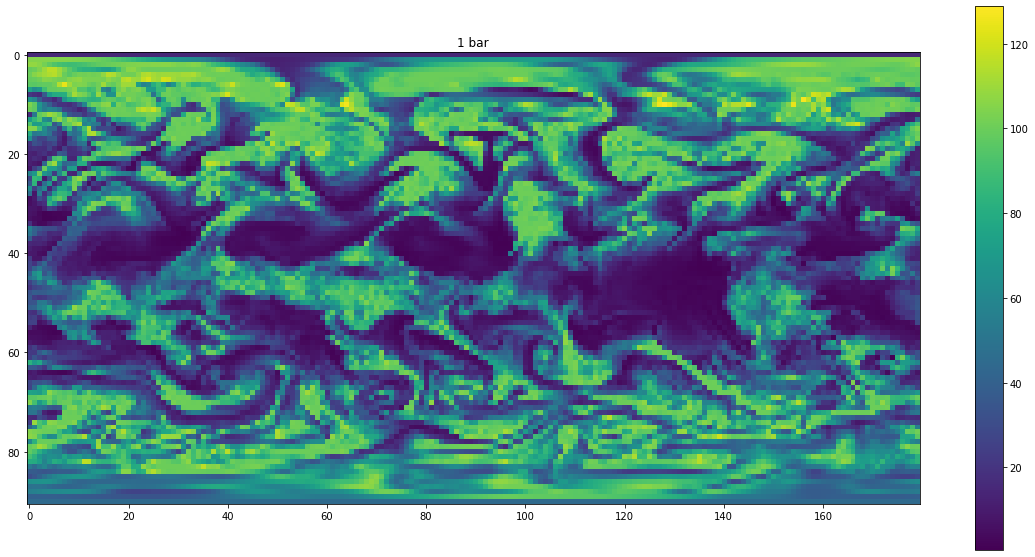

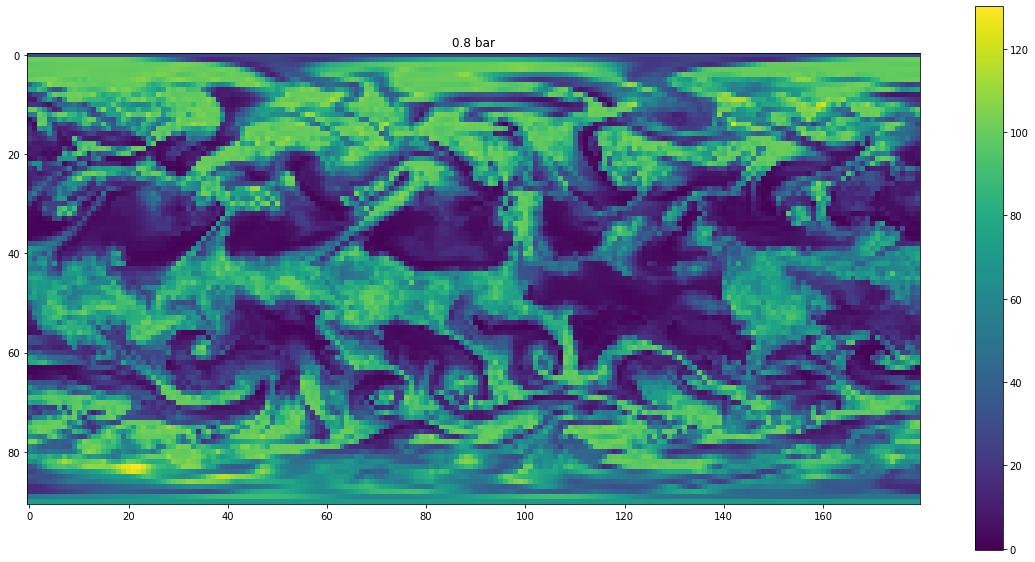

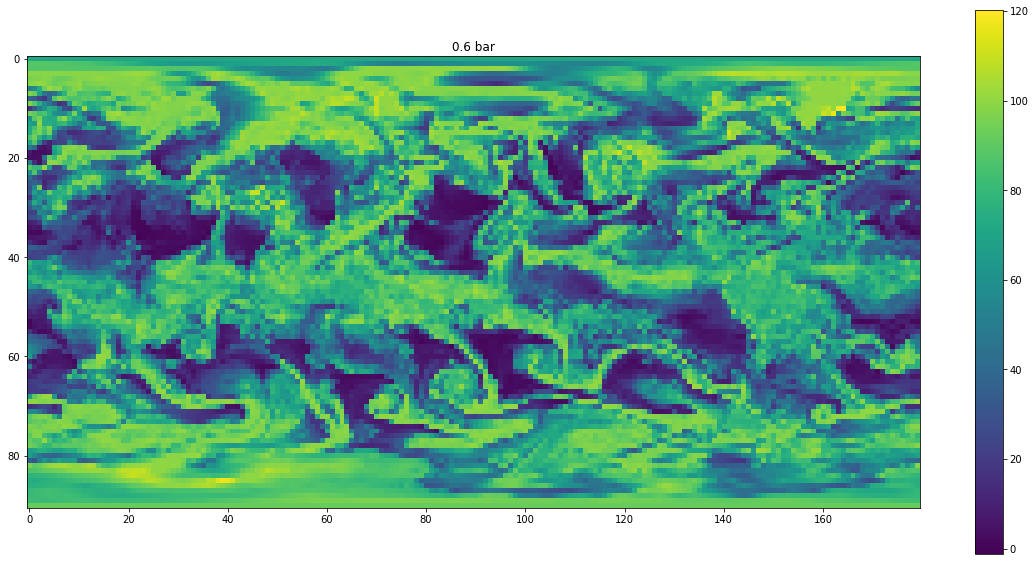

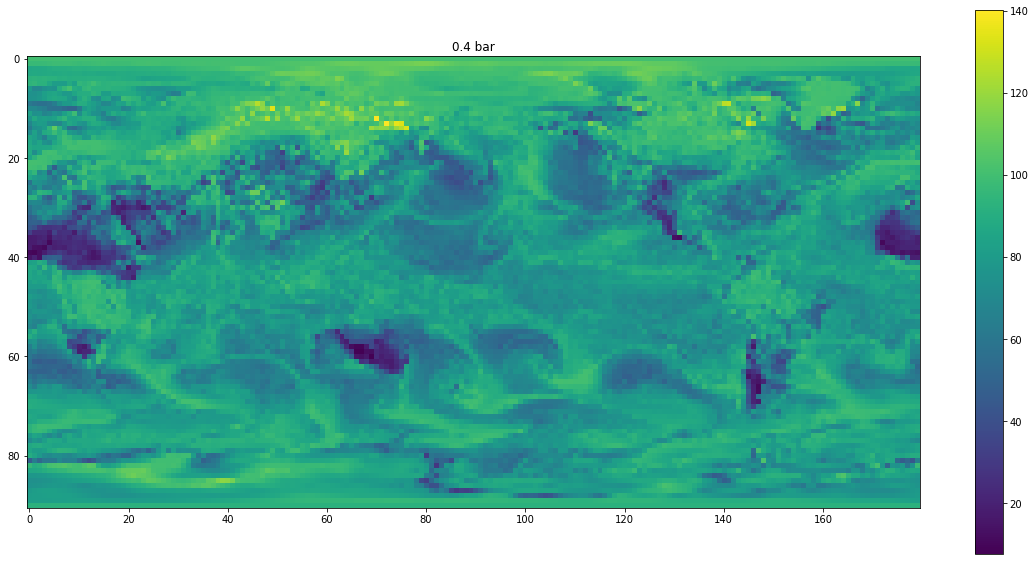

In [5]:
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(train_ds))[:, :, 0, 1])
plt.colorbar()
plt.title('1 bar')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(train_ds))[:, :, 1, 1])
plt.colorbar()
plt.title('0.8 bar')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(train_ds))[:, :, 2, 1])
plt.colorbar()
plt.title('0.6 bar')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(train_ds))[:, :, 3, 1])
plt.colorbar()
plt.title('0.4 bar')

In addition, we are going to use solar radiation data (given in $J/m^2$ ).

In [6]:
solar_data_files_training = ['solar_data/200{}_solar_rad.grib.tfrecords'.format(i) for i in range(5, 8)]
solar_data = load_ds(*solar_data_files_training)

Text(0.5, 1.0, 'Top net thermal radiation')

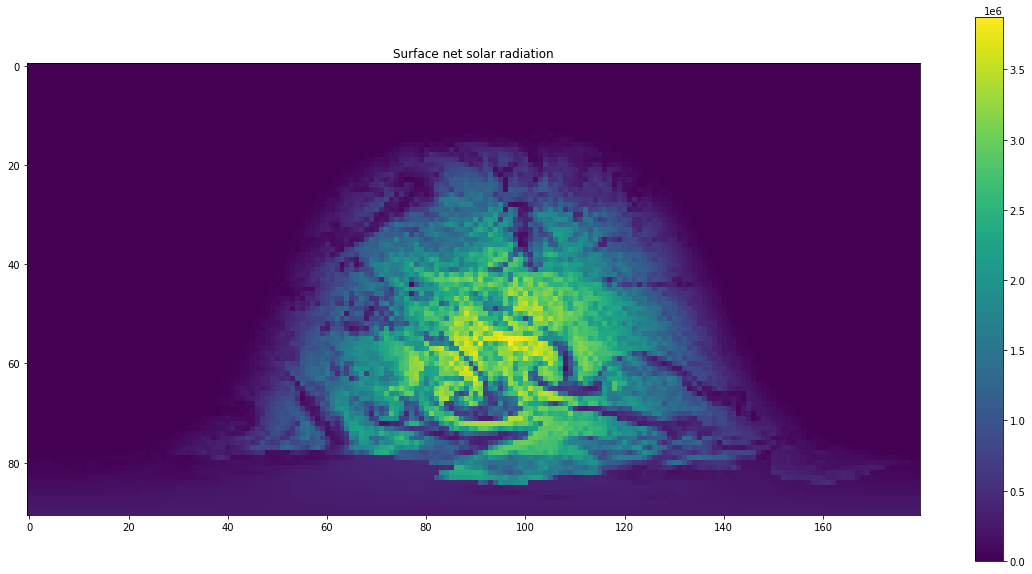

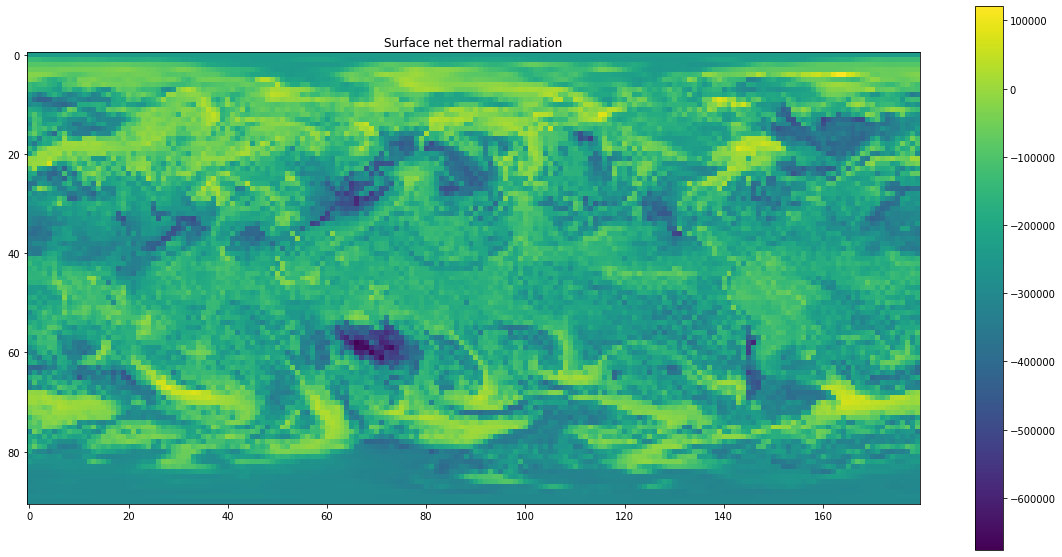

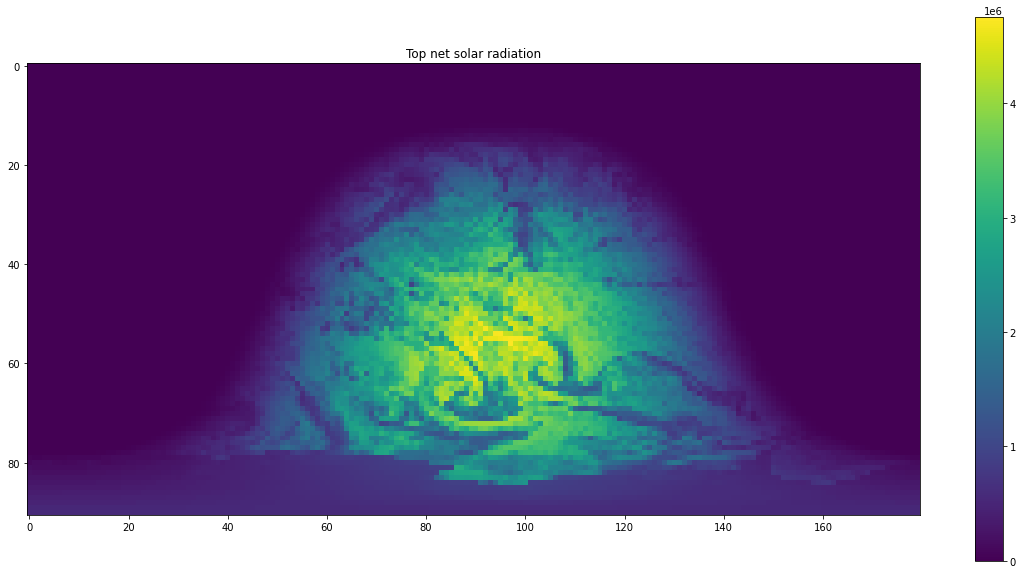

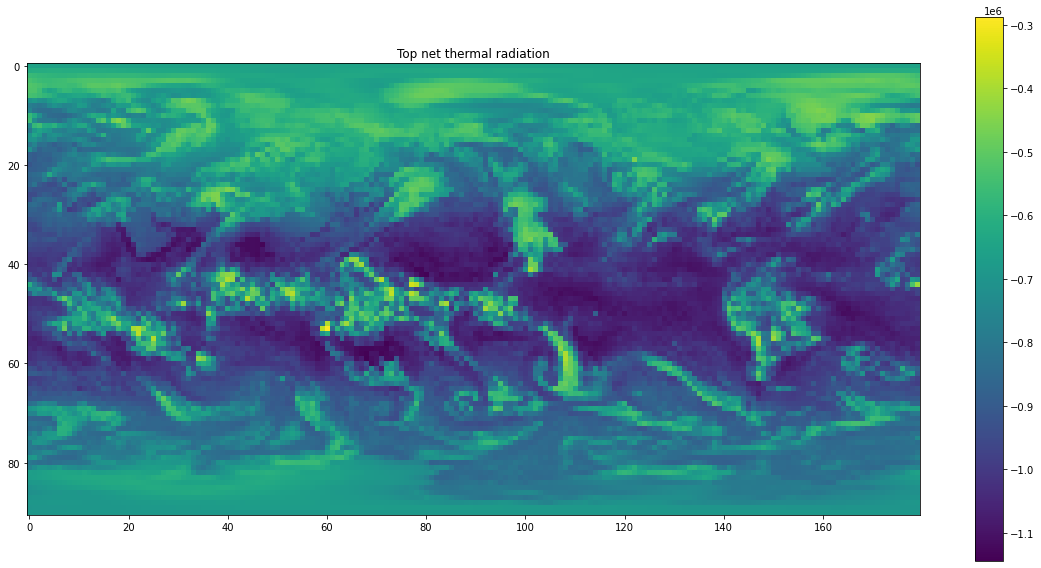

In [7]:
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(solar_data))[:, :, 0])
plt.colorbar()
plt.title('Surface net solar radiation')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(solar_data))[:, :, 1])
plt.colorbar()
plt.title('Surface net thermal radiation')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(solar_data))[:, :, 2])
plt.colorbar()
plt.title('Top net solar radiation')
plt.figure(figsize=(20, 10))
plt.imshow(next(iter(solar_data))[:, :, 3])
plt.colorbar()
plt.title('Top net thermal radiation')

These features will be concatenated, normalized and given into neural network for forecasting.

In [8]:
from input_pipeline import concat_values
#Flattening features along pressures
train_data = train_ds.map(lambda x: tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], -1)))
#Concatenating with radiation values
forecasting_data = concat_values(train_data, solar_data)

In [9]:
#Normalizing features
from normalizer import Normalizer
normalizer = Normalizer()
normalizer.get_stats_nodes(forecasting_data)

Let's look statistical properties of out variables on 4 pressures levels. Note, that they are obtained from lat-lon grid, not from nodes.

In [10]:
from tabulate import tabulate
headers=['geopotential', 'relative humidity', 'temperature', 'lat wind speed', 'long wind speed', 'vertical wind speed']
print(tabulate(tf.reshape(normalizer.node_mean[:24], (4, 6)), headers=headers))
print(tabulate(tf.reshape(normalizer.node_std[:24], (4, 6)), headers=headers))

  geopotential    relative humidity    temperature    lat wind speed    long wind speed    vertical wind speed
--------------  -------------------  -------------  ----------------  -----------------  ---------------------
     69811.6                52.307         242.13           8.36799          -0.0092725           -4.69393e-05
     40492.5                50.2712        260.931          4.49931           0.0125844            0.000812052
     18429                  62.7522        272.005          1.73363          -0.0162408            0.00744728
       722.566              79.6641        279.756         -0.293836         -0.10376              0.0224683
  geopotential    relative humidity    temperature    lat wind speed    long wind speed    vertical wind speed
--------------  -------------------  -------------  ----------------  -----------------  ---------------------
       3968.84              34.3482        12.2728          14.72              11.8344                0.199984
    

Statistical properties of radiation data.

In [11]:
headers=['SNSR', 'SNTR', 'TNSR', 'TNTR']
print(tabulate(tf.expand_dims(normalizer.node_mean[24:], 0), headers=headers))
print(tabulate(tf.expand_dims(normalizer.node_std[24:], 0), headers=headers))

  SNSR     SNTR    TNSR     TNTR
------  -------  ------  -------
495153  -196922  745740  -809216
  SNSR    SNTR         TNSR    TNTR
------  ------  -----------  ------
834705  113794  1.13015e+06  170412


In addition to these features we use ocean/land mask and cos function of latitude.

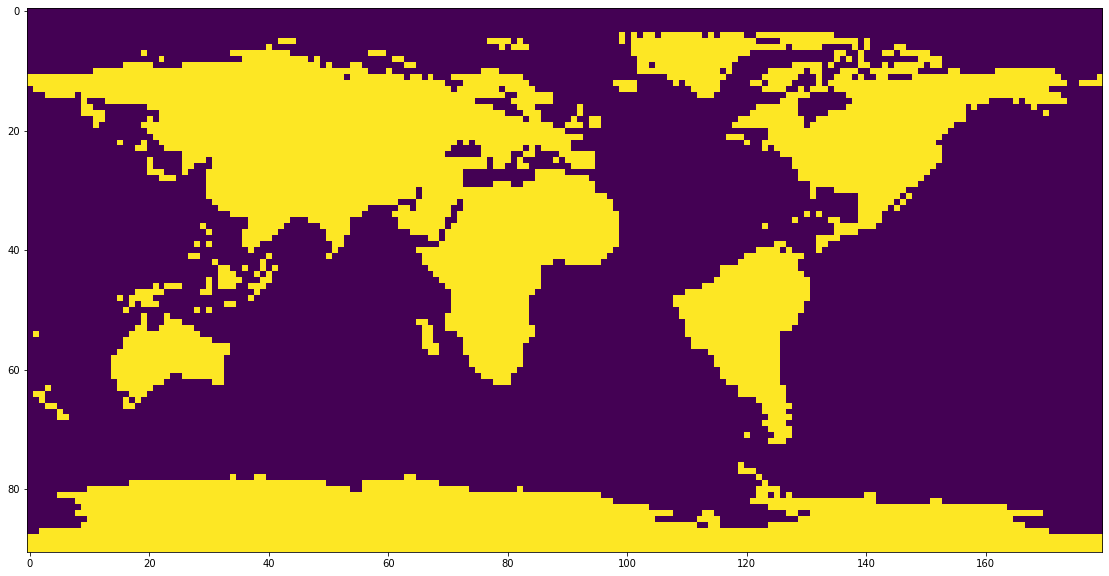

In [12]:
mask = tf.convert_to_tensor(np.load('dataset/ocean_land_mask.npy'))
plt.figure(figsize=(20, 10))
plt.imshow(mask)

Now, converting datasets into format, suitable for training. All the map data is interpolated onto grid and concatenated into edges, edge features, sequential chunk of data and constant values. One can also see data, interpolated onto grids with different resolution.

In [13]:
from input_pipeline import stat_mesh_ds
grid_res = 70
nodes_6000, edges = uniform_mesh(grid_res, grid_res)
edges = tf.transpose(edges)
training_ds_6000 = stat_mesh_ds(concat_values(train_data, solar_data), mask, {'nodes_coords':nodes_6000, 'edges':edges})
grid_res = 50
nodes_3000, edges = uniform_mesh(grid_res, grid_res)
edges = tf.transpose(edges)
training_ds_3000 = stat_mesh_ds(concat_values(train_data, solar_data), mask, {'nodes_coords':nodes_3000, 'edges':edges})

2022-08-08 20:10:04.881755: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x5642a78121c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-08 20:10:04.881789: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2022-08-08 20:10:04.886158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-08-08 20:10:04.951368: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


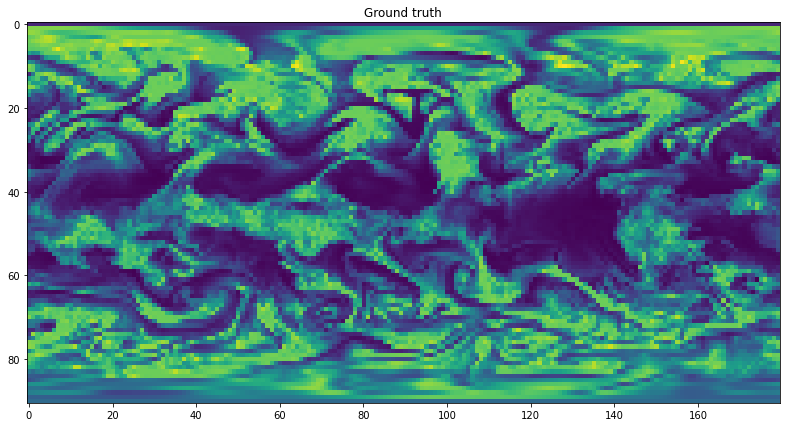

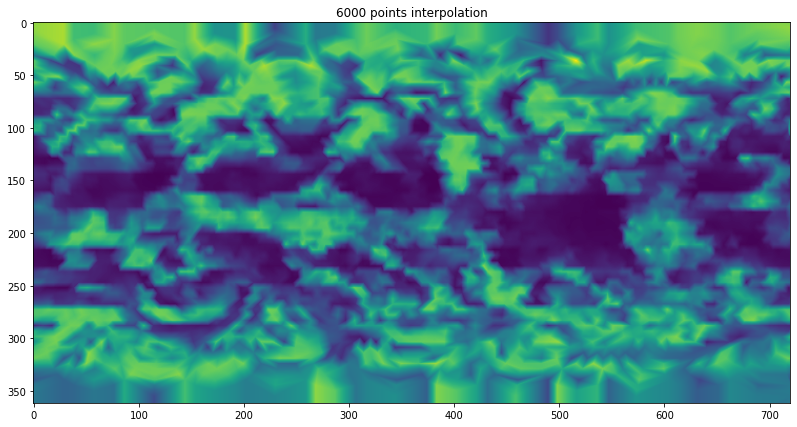

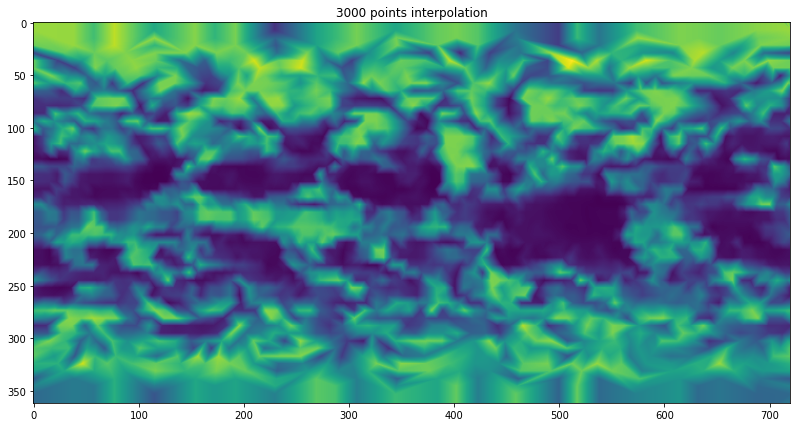

In [14]:
from common import nodes_to_grid
humidity_gt = next(iter(forecasting_data))[:, :, 1]
humidity_3000 = next(iter(training_ds_3000))[2][0][0, :, 1]
humidity_6000 = next(iter(training_ds_6000))[2][0][0, :, 1]
interp_3000 = nodes_to_grid(np.array(humidity_3000), np.array(nodes_3000), res=0.5)
interp_6000 = nodes_to_grid(np.array(humidity_6000), np.array(nodes_6000), res=0.5)
plt.figure(figsize=(15, 7))
plt.title('Ground truth')
plt.imshow(humidity_gt)
plt.figure(figsize=(15, 7))
plt.title('6000 points interpolation')
plt.imshow(interp_6000)
plt.figure(figsize=(15, 7))
plt.title('3000 points interpolation')
plt.imshow(interp_3000)

3. Model training

Creating neural networks structure.

In [17]:
from gnn import Forecaster
gnn_model = Forecaster()

mlp = {'width': 32, 'output': 32}
structure = {'edge_encoder': mlp,
        'node_encoder': mlp,
        'edge_processor': mlp,
        'node_processor': mlp,
        'decoder': {'width': 32, 'output': 28},
              'n_passes': 2}
gnn_model.from_dict(structure)

Getting normalization statistics for training.

In [18]:
nodes_feats = training_ds_3000.map(lambda a, b, c, d: c[0])
edges_feats = training_ds_3000.map(lambda a, b, c, d: b)
normalizer.get_stats_nodes(nodes_feats)
normalizer.get_stats_edges(edges_feats)

Compiling model.

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss = lambda x, y: tf.reduce_mean((x - y)**2)
gnn_model.compile(optimizer, loss, normalizer)

Apparently, I won't train network here. Let's take 10 dataset batches in order to make sure that it works.

In [20]:
gnn_model.fit(training_ds_3000.take(10))

2022-08-08 20:11:07.514775: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162544072 exceeds 10% of free system memory.


      2/Unknown - 36s 16s/step - 0: 1.0036 - 1: 1.0127 - 2: 1.0024 - loss: 3.0188

2022-08-08 20:11:23.838557: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162544072 exceeds 10% of free system memory.


      3/Unknown - 52s 16s/step - 0: 0.9985 - 1: 1.0089 - 2: 1.0154 - loss: 3.0228

2022-08-08 20:11:40.314813: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162544072 exceeds 10% of free system memory.
2022-08-08 20:11:56.563738: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162544072 exceeds 10% of free system memory.


      4/Unknown - 68s 16s/step - 0: 0.9945 - 1: 1.0168 - 2: 1.0235 - loss: 3.0348

2022-08-08 20:12:12.444131: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162544072 exceeds 10% of free system memory.


10/10 [==============================] - 167s 16s/step - 0: 0.9867 - 1: 1.0196 - 2: 1.0178 - loss: 3.0241


Save model.

In [21]:
gnn_model.save('example_model')

INFO:tensorflow:Assets written to: example_model/e_encod/assets
INFO:tensorflow:Assets written to: example_model/n_encod/assets
INFO:tensorflow:Assets written to: example_model/decod/assets
INFO:tensorflow:Assets written to: example_model/e_proc0/assets
INFO:tensorflow:Assets written to: example_model/n_proc0/assets
INFO:tensorflow:Assets written to: example_model/e_proc1/assets
INFO:tensorflow:Assets written to: example_model/n_proc1/assets


We will load ready models for 3000 nodes and for 6000 nodes to find their performance.

In [22]:
normalizer_3000, normalizer_6000 = Normalizer(), Normalizer()
nodes_feats = training_ds_3000.map(lambda a, b, c, d: c[0])
edges_feats = training_ds_3000.map(lambda a, b, c, d: b)
normalizer_3000.get_stats_nodes(nodes_feats)
normalizer_3000.get_stats_edges(edges_feats)
nodes_feats = training_ds_6000.map(lambda a, b, c, d: c[0])
edges_feats = training_ds_6000.map(lambda a, b, c, d: b)
normalizer_6000.get_stats_nodes(nodes_feats)
normalizer_6000.get_stats_edges(edges_feats)

In [25]:
forecaster_3000 = Forecaster()
forecaster_3000.load('3000_model', 5)
forecaster_3000.compile(tf.keras.optimizers.Adam(), lambda x, y: tf.reduce_mean((x - y)**2), normalizer_3000)
forecaster_6000 = Forecaster()
forecaster_6000.load('6000_model', 5)
forecaster_6000.compile(tf.keras.optimizers.Adam(), lambda x, y: tf.reduce_mean((x - y)**2), normalizer_6000)

4. Model evaluation

Firstly, let's see visually how model predicts different physical features on the map on 100 timesteps (200 hours). Since we did not perform any hyperparameter tuning or early stopping on validation dataset, we might use it as testing data.

In [26]:
ground_truth_feats = load_ds('dataset/validation/2011.grib.tfrecords').map(lambda x: tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], -1)))
ground_truth_rad = load_ds('solar_data/2011_solar_rad.grib.tfrecords')
ground_truth = concat_values(ground_truth_feats, ground_truth_rad)
nodes_coords_3000, edges = uniform_mesh(50, 50)
edges = tf.transpose(edges)
val_data_3000 = stat_mesh_ds(ground_truth, mask, {'nodes_coords':nodes_coords_3000, 'edges':edges})
nodes_coords_6000, edges = uniform_mesh(70, 70)
edges = tf.transpose(edges)
val_data_6000 = stat_mesh_ds(ground_truth, mask, {'nodes_coords':nodes_coords_6000, 'edges':edges})

In [27]:
first = next(iter(val_data_3000))
edges_3000, nodes_3000, edge_feats_3000, const_3000 = first[0], first[2][0], first[1], first[-1]
first = next(iter(val_data_6000))
edges_6000, nodes_6000, edge_feats_6000, const_6000 = first[0], first[2][0], first[1], first[-1]

In [29]:
from tqdm import tqdm
predictions_3000 = [nodes_3000]
predictions_6000 = [nodes_6000]
pred_3000 = nodes_3000
pred_6000 = nodes_6000
for i in tqdm(range(100)):
    pred_3000 = forecaster_3000((edges_3000, pred_3000, edge_feats_3000, const_3000))
    pred_6000 = forecaster_6000((edges_6000, pred_6000, edge_feats_6000, const_6000))
    predictions_3000.append(pred_3000)
    predictions_6000.append(pred_6000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


101it [00:52,  1.91it/s]


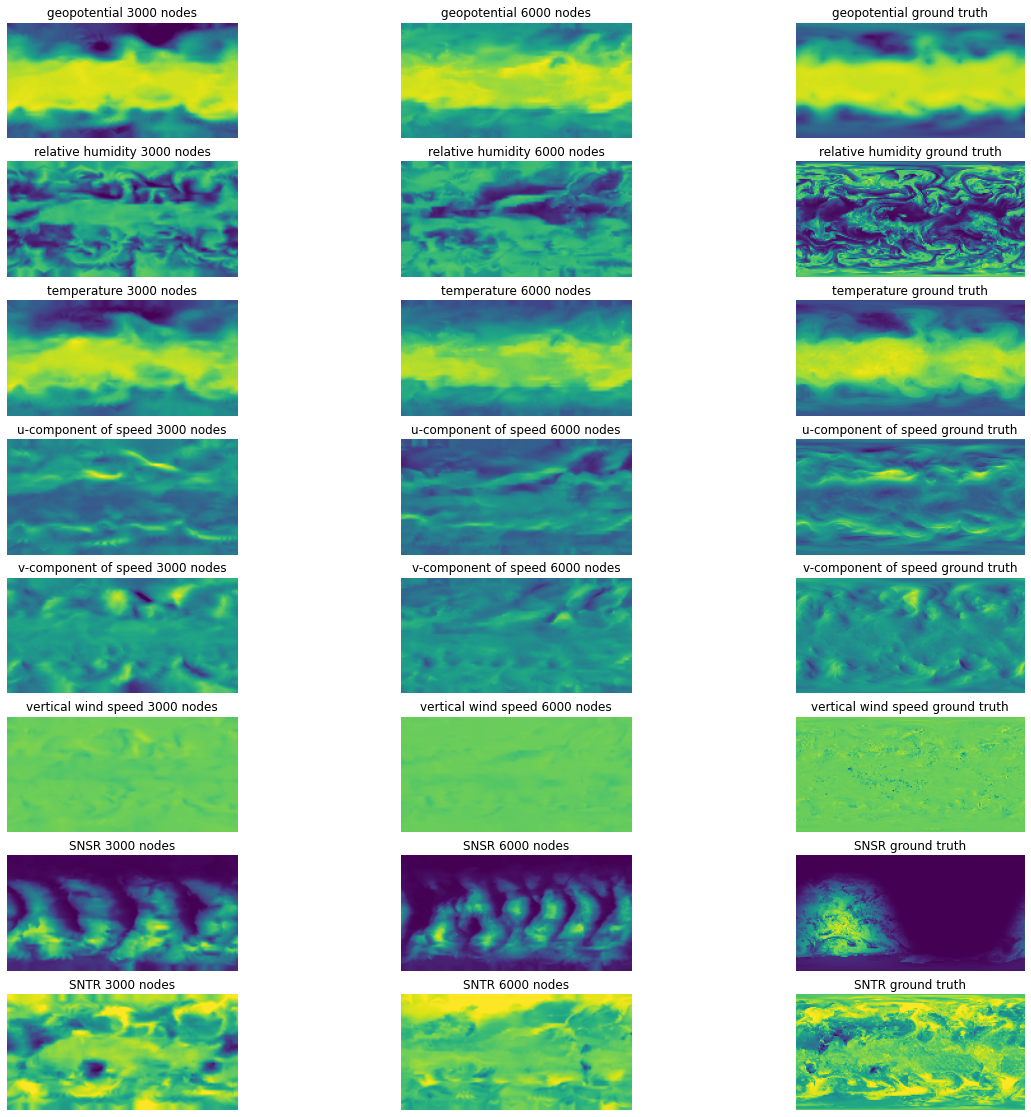

In [30]:
from matplotlib.animation import ArtistAnimation
from common import nodes_to_grid
from IPython import display
fig, axs = plt.subplots(8, 3, figsize=(20, 20))
names = ['geopotential', 'relative humidity', 
         'temperature', 'u-component of speed', 
         'v-component of speed', 'vertical wind speed', 
         'SNSR', 'SNTR']
ims = []
borders = [(62000, 75000), (0, 135), (215, 262), (-45, 75), (-60, 60), (-5, 1.5), (0, 3850000), (-760000, 0)]
plt.ioff()
plt.rcParams['animation.ffmpeg_path'] = 'ffmpeg'
for pred_3000, pred_6000, gt in tqdm(zip(predictions_3000, predictions_6000, iter(ground_truth))):
    im = []
    grid_3000 = nodes_to_grid(np.array(pred_3000[0]), np.array(nodes_coords_3000), res=1)
    grid_6000 = nodes_to_grid(np.array(pred_6000[0]), np.array(nodes_coords_6000), res=1)
    for k, (j, name, (vmin, vmax)) in enumerate(zip(list(range(6)) + list(range(24, 26)), names, borders)):
        axs[k, 0].axis('off')
        axs[k, 0].set_title(name + ' 3000 nodes')
        axs[k, 1].axis('off')
        axs[k, 1].set_title(name + ' 6000 nodes')
        axs[k, 2].axis('off')
        axs[k, 2].set_title(name + ' ground truth')
        im.append(axs[k, 0].imshow(grid_3000[:, :, j], vmin=vmin, vmax=vmax))
        im.append(axs[k, 1].imshow(grid_6000[:, :, j], vmin=vmin, vmax=vmax))
        im.append(axs[k, 2].imshow(gt[:, :, j], vmin=vmin, vmax=vmax))
    ims.append(im)

In [31]:
anim = ArtistAnimation(fig, ims, blit=True, interval=100)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

Now we calulate loss function and for different prediction lengths (taken over entire dataset).

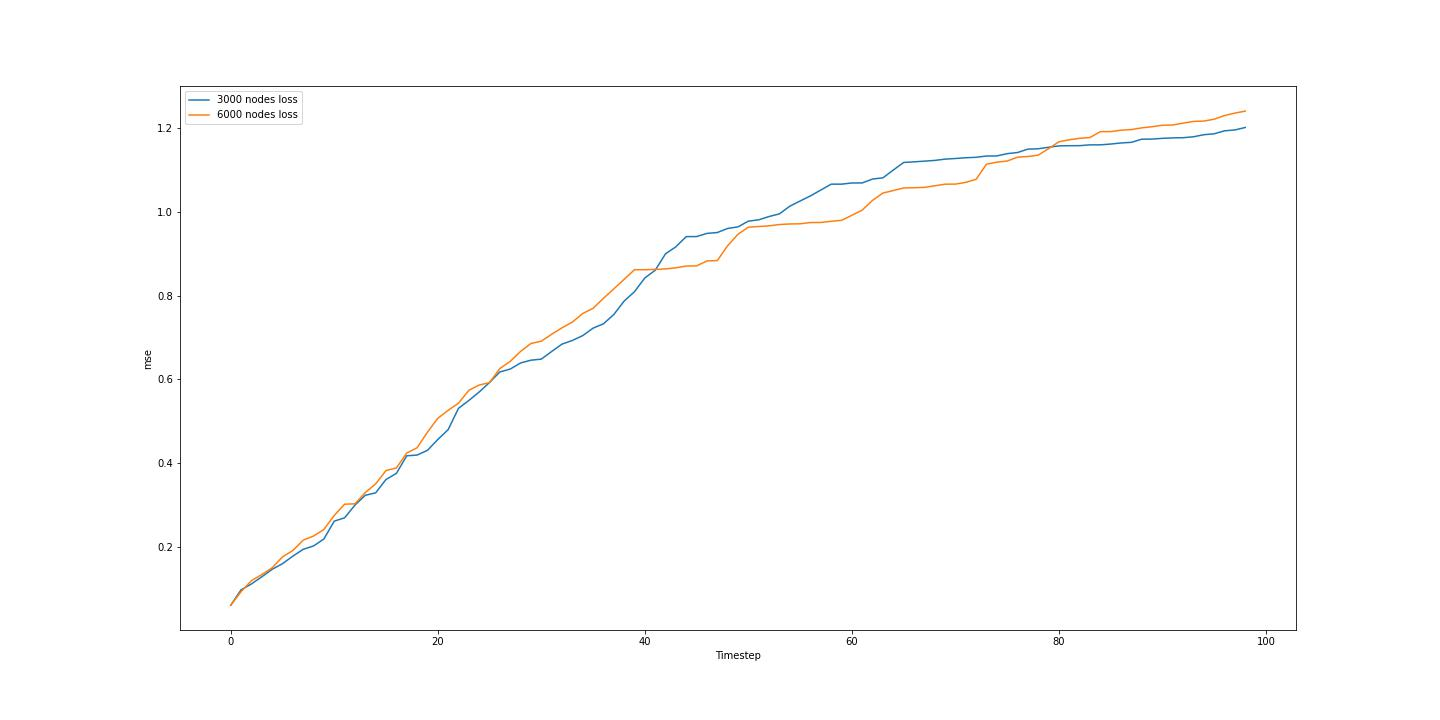

In [32]:
from IPython.display import Image
Image(filename='comp_perf.jpg') 

Let's see r2 scores for different physical values (on first 100 timesteps).

In [34]:
from sklearn.metrics import r2_score
errors_3000 = []
errors_6000 = []
for pred_3000, pred_6000, gt_3000, gt_6000 in zip(predictions_3000, predictions_6000, iter(val_data_3000), iter(val_data_6000)):
    ers_3000 = []
    ers_6000 = []
    for i in range(28):
        ers_3000.append(r2_score(gt_3000[2][0][0, :, i], pred_3000[0, :, i]))
        ers_6000.append(r2_score(gt_6000[2][0][0, :, i], pred_6000[0, :, i]))
    errors_3000.append(ers_3000)
    errors_6000.append(ers_6000)

In [35]:
errors_3000 = np.array(errors_3000)
errors_6000 = np.array(errors_6000)

Text(0.5, 1.0, '6000 nodes')

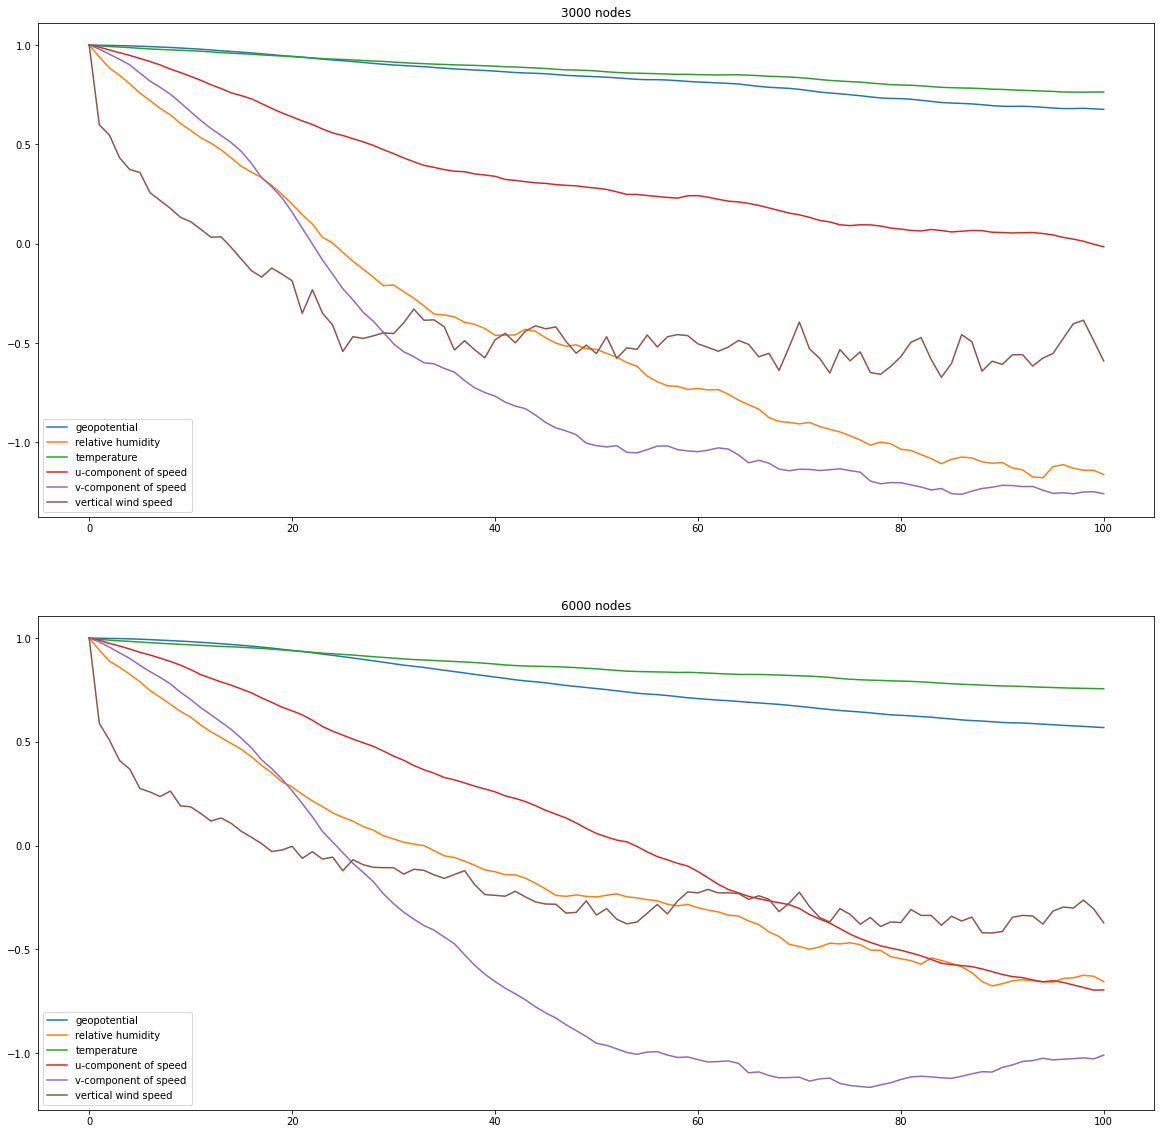

In [36]:
vals = ['geopotential', 'relative humidity', 
         'temperature', 'u-component of speed', 
         'v-component of speed', 'vertical wind speed']
fig, axs = plt.subplots(2, 1, figsize=(20, 20))
for i, val in enumerate(vals):
    axs[0].plot(errors_3000[:, i], label=val)
    axs[1].plot(errors_6000[:, i], label=val)
axs[0].legend()
axs[1].legend()
axs[0].set_title('3000 nodes')
axs[1].set_title('6000 nodes')

Errors of relative humidity on different pressure levels.

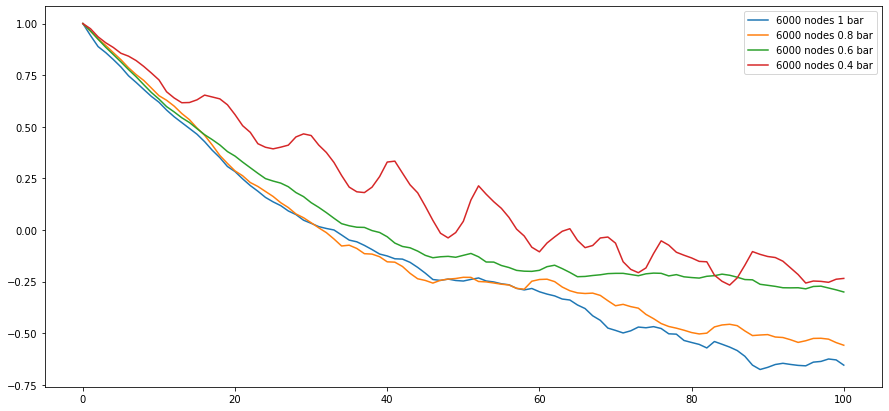

In [37]:
plt.figure(figsize=(15, 7))
lvls=['1 bar', '0.8 bar', '0.6 bar', '0.4 bar']
for i, lvl in zip(range(1, 24, 6), lvls):
    plt.plot(errors_6000[:, i], label='6000 nodes ' + lvl)
plt.legend()

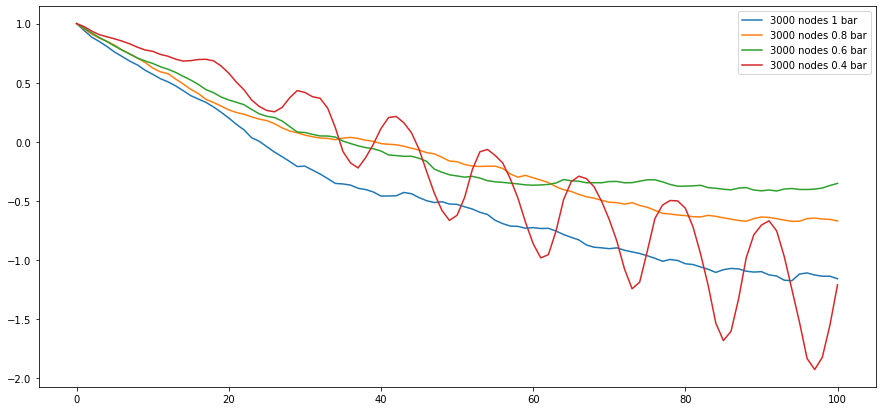

In [38]:
plt.figure(figsize=(15, 7))
lvls=['1 bar', '0.8 bar', '0.6 bar', '0.4 bar']
for i, lvl in zip(range(1, 24, 6), lvls):
    plt.plot(errors_3000[:, i], label='3000 nodes ' + lvl)
plt.legend()

Surprisingly, both models have approximately same accuracy.

5. Adaptive mesh assumptions

The main purpose of adaptive mesh would be description of more complex parts with better resolution. For this we would like to somehow find what complexity means. Let's introduce reverse interpolation error as a measure of mesh's quality. 

Firstly, one should take a look at different physical values surfaces. (Geopotential, relative humidity, temperatures, speeds)

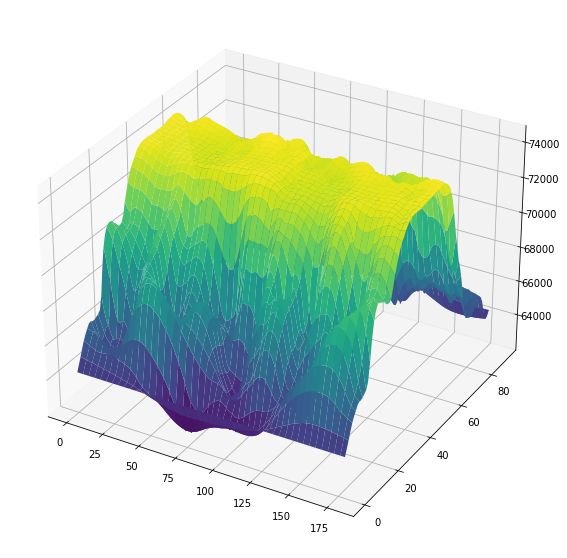

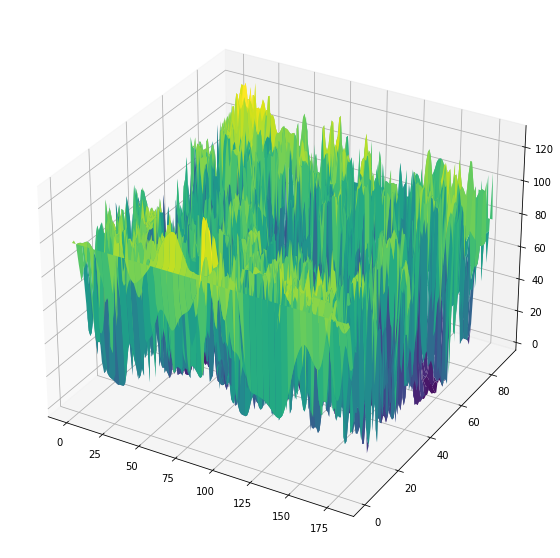

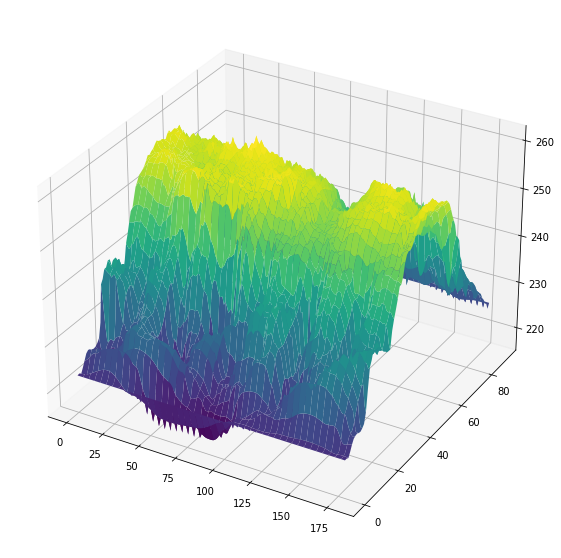

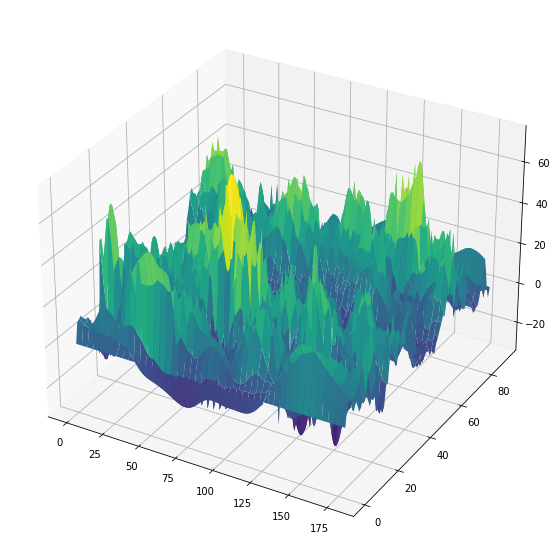

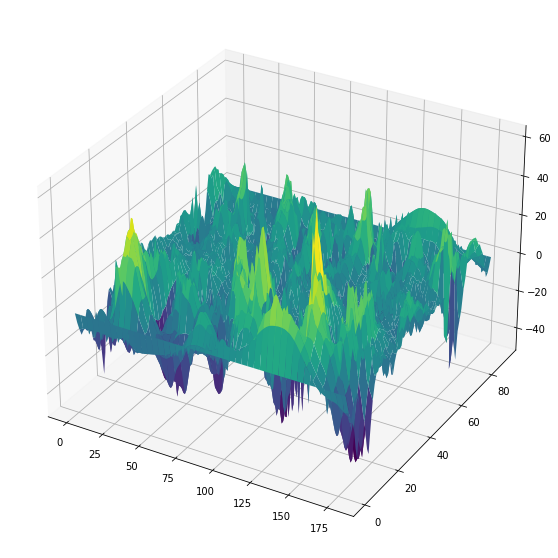

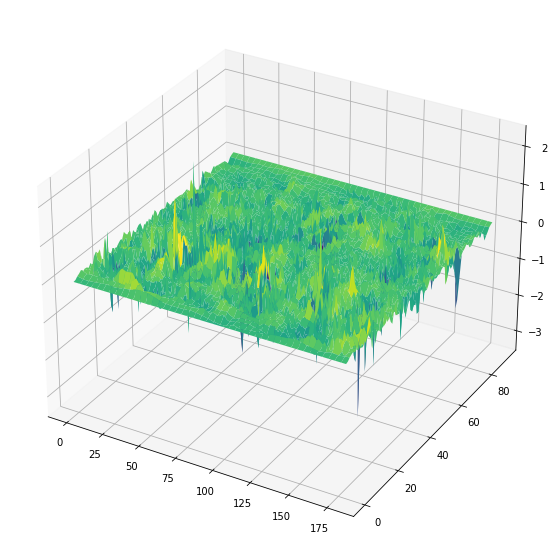

In [39]:
grid_gt = next(iter(ground_truth))
import numpy as np
import matplotlib.pyplot as plt
x = np.array(range(180))
y = np.array(range(91))
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, grid_gt[:, :, 0], cmap='viridis', edgecolor='none')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, grid_gt[:, :, 1], cmap='viridis', edgecolor='none')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, grid_gt[:, :, 2], cmap='viridis', edgecolor='none')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, grid_gt[:, :, 3], cmap='viridis', edgecolor='none')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, grid_gt[:, :, 4], cmap='viridis', edgecolor='none')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, grid_gt[:, :, 5], cmap='viridis', edgecolor='none')
plt.show()

From these plots we can interpret why description of relative humidity and speeds is so difficult, compared to temperature and geopotential. We would not really be able to build adaptive mesh on such manifold. However, we can on some region with finer resolution. Let's use 32-42 lat 55-65 lon (approx. moscow region) map in 20-30 july 2022 period with 0.25 resolution to see, for example, relative humidity there.

In [40]:
data = xr.load_dataset('moscow.grib', engine='cfgrib').to_array().to_numpy()[0]

Ignoring index file 'moscow.grib.923a8.idx' older than GRIB file


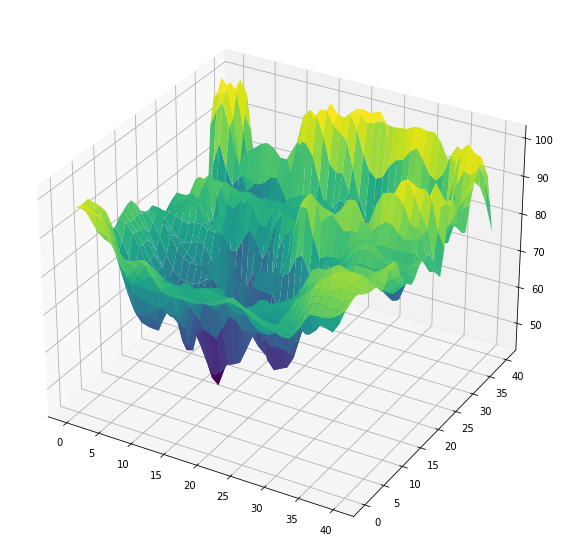

In [41]:
x = np.array(range(41))
y = np.array(range(41))
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, data[0], cmap='viridis', edgecolor='none')
plt.show()

From this plot we can see a much smoother surface. Now one might try to find coarser mesh, approximating our surface with better precision using criteria above.

In [42]:
def_grid = np.indices((41, 41))
def_grid = np.transpose(def_grid, axes=[1, 2, 0])
coarse_regular = def_grid[::4, ::4].reshape((-1, 2))

In [43]:
grid_x, grid_y = np.mgrid[0:41, 0:41]
from scipy.interpolate import griddata
def interpolation(grid_points, data):
    grid_values = data[grid_points[:, 0], grid_points[:, 1]]
    interpolation = griddata(grid_points, grid_values, (grid_x, grid_y),method='linear', fill_value=0)
    return interpolation

Text(0.5, 1.0, 'ground truth')

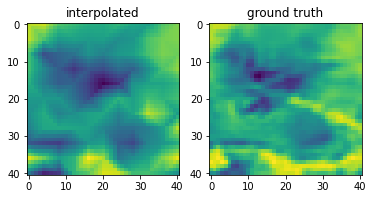

In [44]:
fig, axs=plt.subplots(1, 2)
axs[0].imshow(interpolation(coarse_regular, data[0]))
axs[0].set_title('interpolated')
axs[1].imshow(data[0])
axs[1].set_title('ground truth')

We can see visually how bad our regular subgrid approximates data. One might try to find better one by random enumeration (a. k. a. "lazy" annealing).

In [45]:
def make_step(grid_coords, n_nodes):
    random_steps_lat = np.random.randint(-1, 2, size=n_nodes)
    random_steps_long = np.random.randint(-1, 2, size=n_nodes)
    nodes_to_move = np.random.choice(np.array(range(grid_coords.shape[0])), size=n_nodes)
    grid_coords_new = np.copy(grid_coords)
    for dlat, dlong, node in zip(random_steps_lat, random_steps_long, nodes_to_move):
        new_coords = np.mod(grid_coords_new[node] + [dlat, dlong], [41, 41])
        if not(any((grid_coords_new[:]==new_coords).all(1))):
            grid_coords_new[node] = np.mod(grid_coords_new[node] + [dlat, dlong], [41, 41])
    return grid_coords_new

In [46]:
def interpolation_error(grid_points, data):
    grid_values = data[grid_points[:, 0], grid_points[:, 1]]
    interpolation = griddata(grid_points, grid_values, (grid_x, grid_y),method='linear', fill_value=0)
    return ((interpolation - data)**2).mean()

In [47]:
current_state = np.copy(coarse_regular)
current_error = interpolation_error(current_state, data[0])
error_stats = []
for i in range(20000):
    new_state = make_step(current_state, 5)
    new_error = interpolation_error(new_state, data[0])
    error_stats.append(current_error)
    print(i, ': ', current_error, end='\r')
    if new_error < current_error:
        current_error = new_error
        current_state = new_state

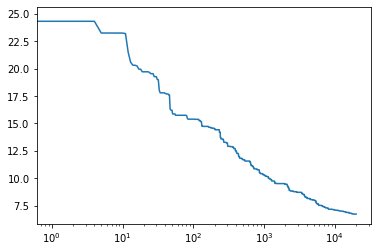

In [48]:
plt.plot(error_stats)
plt.xscale('log')

Now one can visually make sure that we've obtained better mesh with 16x less nodes than our initial 1 degree res grid.

Text(0.5, 1.0, 'Refined mesh')

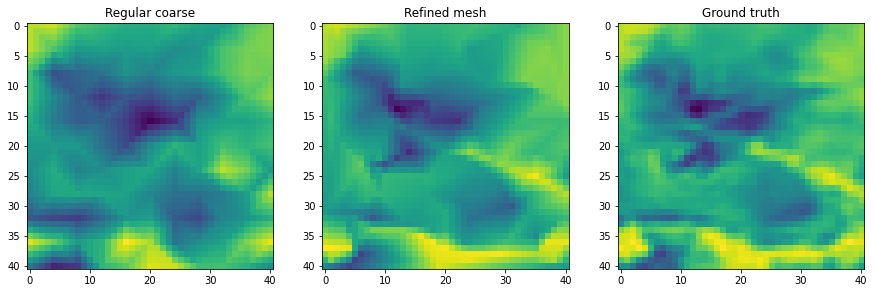

In [49]:
fig, axs=plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(interpolation(coarse_regular, data[0]))
axs[0].set_title('Regular coarse')
axs[2].imshow(data[0])
axs[2].set_title('Ground truth')
axs[1].imshow(interpolation(current_state, data[0]))
axs[1].set_title('Refined mesh')

Another interesting question is how often our mesh should be refined. One can see how interpolation error changes during time.

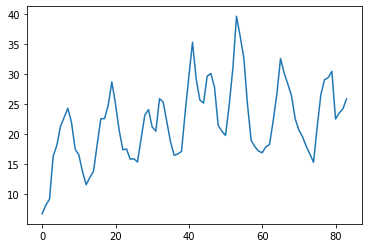

In [50]:
error = []
for frame in data:
    error.append(interpolation_error(current_state, frame))
plt.plot(error)

Refining mesh after timestep.

In [51]:
init_fine_mesh = np.copy(current_state)
current_state = np.copy(init_fine_mesh)
current_error = interpolation_error(current_state, data[1])
error_stats = []
for i in range(20000):
    new_state = make_step(current_state, 5)
    new_error = interpolation_error(new_state, data[1])
    error_stats.append(current_error)
    print(i, ': ', current_error, end='\r')
    if new_error < current_error:
        current_error = new_error
        current_state = new_state

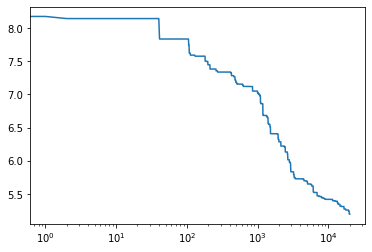

In [52]:
plt.plot(error_stats)
plt.xscale('log')